In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Defining keplerian elements given by previous functions (cart2kep)
#Orbital Parameters    
a = 7719.637186          
e  =   0.000493          
i   =  1.152689          
w   =  1.161349          
W   =  3.167019          
V   =  5.501897
GM = 398600.4415

In [3]:
#Defining radial distance and semi-latus rectum given by Kep2Cart
p = a * (1 - (e ** 2))

r = p / (1 + e * np.cos(V))

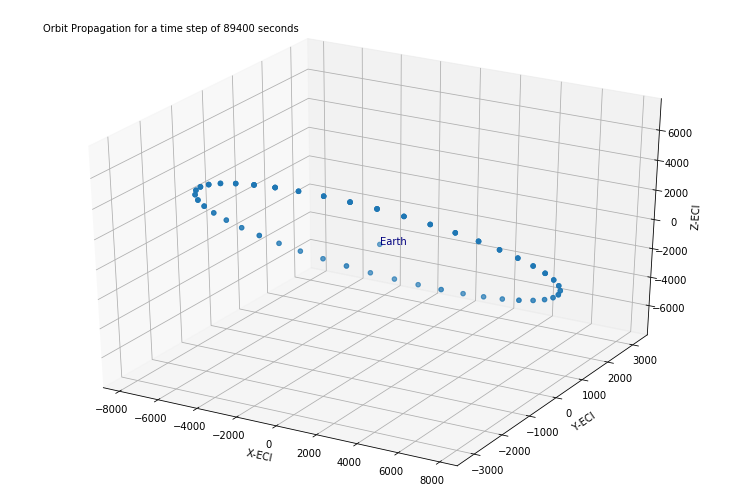

In [4]:
########## TESTING ############

#creating empty lists in which the xyz coordinates will be appended for each new time step - dt
#The three 0's represent the centre of mass of the earth
cart_pos_x_new_list = [0]
cart_pos_y_new_list = [0]
cart_pos_z_new_list = [0]

#empty list to store the time step in each iteration
time_since_prop = [0]

#creating empty lists in which the uvw velocities will be appended for each new time step - dt
cart_vel_x_new_list = [0]
cart_vel_y_new_list = [0]
cart_vel_z_new_list = [0]
 
for newdt in range (0,90000,600):

    #Compute the mean motion
    n = np.sqrt(GM/(a**3))

    # Compute the eccentric anomaly at t=t0
    cos_Eo = ((r * np.cos(V)) / a) + e
    sin_Eo = (r * np.sin(V)) / (a * np.sqrt(1 - e ** 2))

    # adding 2 pi for for very small values ensures that Eo stays in the range 0< Eo <2Pi
    Eo = math.atan2(sin_Eo, cos_Eo)
    if Eo < 0.0:
        Eo = Eo + 2 * np.pi
    else:
        Eo = Eo

    # Compute mean anomaly at start point
    Mo = Eo - e * np.sin(Eo)  # From Kepler's equation

    # Compute the mean anomaly at t+newdt
    Mi = Mo + n * newdt

    # Solve Kepler's equation to compute the eccentric anomaly at t+newdt
    M = Mi

    #Minimal value approaching 0 (level of accuracy)
    min_val = 1E-7

    #Initial Guess at Eccentric Anomaly (taken these conditions from Fundamentals of Astrodynamics by Roger.E.Bate)
    if M < np.pi:
        E = M + (e / 2)
    if M > np.pi:
        E = M - (e / 2)

    #Initial Conditions
    f = E - e*np.sin(E) - M
    f_prime = 1 - e*np.cos(E)
    ratio = f / f_prime

    #Numerical iteration for ratio compared to level of accuracy wanted

    iteration_array = []
    while abs(ratio) > min_val:
        f = E - e*np.sin(E) - M
        f_prime = 1 - e*np.cos(E)
        ratio = f / f_prime

        iteration_array.append(1)

        if abs(ratio) > min_val:
             E = E - ratio
        if abs(ratio) < min_val:
            break

    Ei = E

    # Compute the gaussian vector component x,y
    x_new = a * (np.cos(Ei) - e)
    y_new = a * ((np.sqrt(1 - e ** 2)) * (np.sin(Ei)))

    # Compute the in-orbital plane Gaussian Vectors
    # This gives P and Q in ECI components

    P = np.matrix([[np.cos(W) * np.cos(w) - np.sin(W) * np.cos(i) * np.sin(w)],
                    [np.sin(W) * np.cos(w) + np.cos(W) * np.cos(i) * np.sin(w)],
                    [np.sin(i) * np.sin(w)]])

    Q = np.matrix([[-np.cos(W) * np.sin(w) - np.sin(W) * np.cos(i) * np.cos(w)],
                    [-np.sin(W) * np.sin(w) + np.cos(W) * np.cos(i) * np.cos(w)],
                    [np.sin(i) * np.cos(w)]])

    
    
    # Compute the position vector at t+newdt
    # We know the inertial vector components along the P and Q vectors.
    # Thus we can project the satellite position onto the ECI basis.

    #calcualting the new x coordiante
    cart_pos_x_new = (x_new * P.item(0)) + (y_new * Q.item(0))
    #appending the newly created coordinate to the list created at the top
    cart_pos_x_new_list.append(cart_pos_x_new)
    
    #repeat for other two coordinates
    cart_pos_y_new = (x_new * P.item(1)) + (y_new * Q.item(1))
    cart_pos_y_new_list.append(cart_pos_y_new)
    
    cart_pos_z_new = (x_new * P.item(2)) + (y_new * Q.item(2))
    cart_pos_z_new_list.append(cart_pos_z_new)
     
    #Adding the new dt to the list
    time_since_prop.append(newdt)
        
    # Compute the range at t+dt
    r_new = a * (1 - e * (np.cos(Ei)))

    # Compute the gaussian velocity components
    cos_Ei = ((x_new / a) + e)
    sin_Ei = (y_new / a * np.sqrt(1 - e ** 2))

    f_new = (np.sqrt(a * GM)) / r_new
    g_new = np.sqrt(1 - e ** 2)

#####TODO###### - Check if we actually need/want velocity here ?

    #calcualting the new u coordiante
    cart_vel_x_new = (-f_new * sin_Ei * P.item(0)) + (
            f_new * g_new * cos_Ei * Q.item(0))  # x component of velocity - a.k.a 'u'
    #appending the newly created coordinate to the list created at the top
    cart_vel_x_new_list.append(cart_vel_x_new)
    
    
    #repeat for other two coordinates
    cart_vel_y_new = (-f_new * sin_Ei * P.item(1)) + (
            f_new * g_new * cos_Ei * Q.item(1))  # y component of velocity - a.k.a 'v'
    cart_vel_y_new_list.append(cart_vel_y_new)
    
    cart_vel_z_new = (-f_new * sin_Ei * P.item(2)) + (
            f_new * g_new * cos_Ei * Q.item(2))  # z component of velocity - a.k.a 'w'
    cart_vel_z_new_list.append(cart_vel_z_new)

#Turning lists into arrays so that I can add them to pandas dataframe
xnew = np.asarray(cart_pos_x_new_list)
ynew = np.asarray(cart_pos_y_new_list)
znew = np.asarray(cart_pos_z_new_list)

unew = np.asarray(cart_vel_x_new_list)
vnew = np.asarray(cart_vel_y_new_list)
wnew = np.asarray(cart_vel_z_new_list)

#Loading the new cartesian coordinates into a Pandas dataframe
Ephemeris = pd.DataFrame(
    {
    "x-coordinates": xnew,
    "y-coordinates": ynew , 
    "z-coordinates": znew ,
    "time dt": time_since_prop,
    "u-coordinates": unew,
    "v-coordinates": vnew , 
    "w-coordinates": wnew ,
                                                                   }
)

#Plotting outside of the loop (once completed) so that the entire list can be plotted

fig = plt.figure(figsize=(13,9))
ax = fig.add_subplot(projection='3d')
zdata = [cart_pos_z_new_list[0:newdt]] 
xdata = [cart_pos_x_new_list[0:newdt]]
ydata = [cart_pos_y_new_list[0:newdt]] 

ax.scatter3D(xdata, ydata, zdata)
ax.set_xlabel('X-ECI')
ax.set_ylabel('Y-ECI')
ax.set_zlabel('Z-ECI')
ax.text(0, 0, 0, "Earth", color='navy')
#This adjusts the title in accordance with the selected time step
ax.text2D(0.05, 0.95, "Orbit Propagation for a time step of %i seconds" %newdt, transform=ax.transAxes)
plt.show()

In [5]:
#Dataframe containing XYZ and UVW at all given time steps for the given time frame
Ephemeris

,x-coordinates,y-coordinates,z-coordinates,time dt,u-coordinates,v-coordinates,w-coordinates
0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
1,-7134.401598,-1344.205350,2616.199171,0,2.737023,-2.641275,6.099438
2,-4490.992612,-2643.261896,5690.311947,600,5.844011,-1.575551,3.879363
3,-480.930143,-3137.920607,7032.745550,1200,7.173072,-0.030176,0.478347
4,3675.539088,-2677.699496,6235.094293,1800,6.319436,1.523991,-3.067347
...,...,...,...,...,...,...,...
146,-7352.862050,795.785945,-2211.243314,87000,-2.177995,-2.827446,6.237075
147,-7475.036936,-934.773598,1675.493544,87600,1.781895,-2.790270,6.380019
148,-5323.649542,-2380.959267,5052.490158,88200,5.202072,-1.904167,4.582011
149,-1552.322519,-3102.603262,6891.975852,88800,7.040082,-0.438350,1.389121
